TLDR : use DECAPS IMDB catalog containing headers from all DECAPS single-epoch images / catalogs, and MAF simulated sky, to obtain images at different densities. 

In [4]:
# Imports 

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.table import Column
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.table import hstack
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
import numpy as np
from astropy.io import fits

In [5]:
# Load DECAPS image database 
image_database = '../raw_data/decaps_catalogs/imdb.fits'
imdb_hdu = fits.open(image_database)
imdb = Table(imdb_hdu[1].data)

In [6]:
#np.ravel(imdb.colnames)

In [7]:
# Load MAF simulated sky ...

# Load the data, copy the keys into variables
data = np.load('../raw_data/catalogs/starDensity_r_nside_64.npz')

# the data consists of 
# data['starDensity'],  expressed as stars / sq. deg  ,  per pixel, per magnitude
# data['bins'], defining the magnitude ranges for each of the 65 magnitude bins 
# data['overMaxMask'], which tells where there are more than 1e6 stars 

# Cumulative number counts, units of stars/sq deg. Array at healpix locations
starDensity = data['starDensity'].copy()
# magnitude bins 
bins = data['bins'].copy()
# pixels where there were so many  (1e6 ) stars some were skipped
mask = data['overMaxMask'].copy()

# select only bins up to 24.5  - then selecting the final bin will 
# give us the source count up to depth of 24.5 mag 
bright_mags, = np.where(bins<24.5)
faintest_mag_bin = bright_mags[-1]

# Since the data is already cumulative, just choose the  last bin: 
# this will have the number of stars up to the faintest magnitude 
# bin in a given  healpixel 
starDensity_lt_245 = data['starDensity'][:,faintest_mag_bin]

# Generate the ra, dec array from healpy
nside = hp.npix2nside(np.size(mask))
lat,ra = hp.pix2ang(nside, np.arange(np.size(mask)))
dec = np.pi/2-lat

# only select those healpixels for which we have any simulation data ...
m = starDensity_lt_245 > 0

density = starDensity_lt_245[m]
ra = ra[m]
dec = dec[m]

# For each pixel calculate how many pixels have a higher or equal density 
N_px_greater  = np.zeros_like(density)
for i in range(len(density)):
    N_px_greater[i]=np.sum(density>=density[i])
    
# calculate the fraction of pixels that have a higher density (by area)
frac_greater  = N_px_greater /  len(density)

# Make an AstroPy table with healpix data...

healpix_table = Table([density, ra,dec, N_px_greater, frac_greater], 
                      names=('source_density','ra_rad','dec_rad', 'N_px_greater', 
                             'frac_greater'))



In [8]:
# Match positionally DECAPS to MAF table : 

# express pixel coordinates as SkyCoord object, 
healpix_coords = SkyCoord(ra,dec, frame='icrs', unit='rad')

# express the decaps field coordinates as SkyCoord object ..
decaps_coords = SkyCoord(ra = imdb['ra'].data, dec = imdb['dec'].data, 
                       unit='degree', frame='icrs')




In [9]:
#healpix_table['source_density']

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/projections/geo.py:493: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


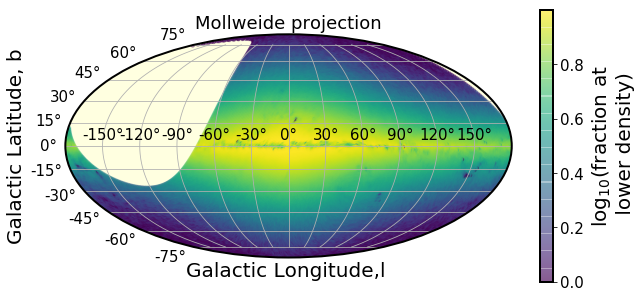

In [10]:
#
# for plotting  in mollweide projection ... 
# 
# express the MAF healpixel coords in galactic 
# coords,  in degrees 
longitude = healpix_coords.galactic.l.deg
latitude  = healpix_coords.galactic.b.deg

# possibility to center the map on 0 or 180...
origin = 0
x = np.remainder(longitude+360-origin,360) # shift RA values
ind = x>180
x[ind] -=360    # scale conversion to [-180, 180]
x=-x    # reverse the scale: East to the left
tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
tick_labels = np.remainder(tick_labels+360+origin,360)

# color by the fraction of pixels at greater density (or 1 - that)
z = frac_greater


# Plot in Mollweide projection the MAF densities 
# in Galactic coordinates 
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='mollweide', facecolor ='LightYellow')

# convert degrees to radians
imge = ax.scatter(np.radians(x),np.radians(latitude),  alpha=0.4,s=14, c=1-z)  

# also overplot the decaps objects..
overplot_decaps = False 
if overplot_decaps : 
    longitude = decaps_coords.galactic.l.deg
    latitude  = decaps_coords.galactic.b.deg
    x = np.remainder(longitude+360-origin,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    ax.scatter(np.radians(x), 
               np.radians(latitude), 
               alpha=0.4, s=14, c = 'red')

    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    i += 1 

title='Mollweide projection'
ax.set_title(title)
xlabel='Galactic Longitude,l '
ylabel='Galactic Latitude, b'
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.grid(True)
#plt.legend(fontsize=14)
plt.colorbar(imge, label=r'$\log_{10}$'+'(fraction at\n lower density)')
plt.savefig('../data_products/MAF_density_definitions/MAF_densities.png', 
            bbox_inches='tight')

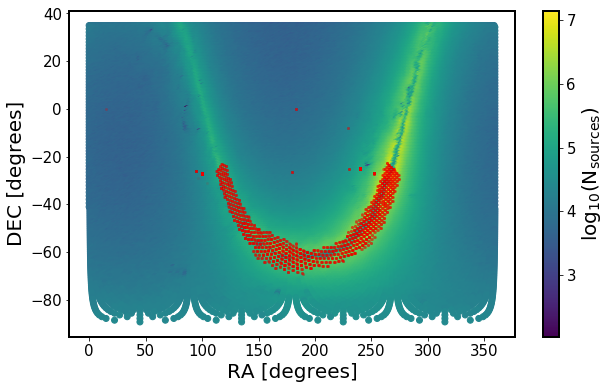

In [11]:
z = np.log10(healpix_table['source_density'].data)
fig,ax = plt.subplots(1,1,figsize=(10,6))
image = ax.scatter(healpix_coords.ra.deg, healpix_coords.dec.deg,c=z)
ax.scatter(decaps_coords.ra.deg, decaps_coords.dec.deg, alpha=0.07,c='red',s =4)
ax.set_xlabel('RA [degrees]')
ax.set_ylabel('DEC [degrees]')
plt.colorbar(image, label=r'$\log_{10}(\mathrm{N}_{\mathrm{sources}})$')
plt.savefig('../data_products/MAF_density_definitions/MAF_DECAPS_sources.png',
           bbox_inches='tight')

In [12]:

# visit comes from dtacqnam 
x1 = len('/data_local/images/DTS/2016A-0327/DECam_00')
x2 = len('.fits.fz')
visit = [line[x1:-x2] for line in imdb['dtacqnam'].data.astype(str)]
imdb['visit'] = visit


In [13]:
# grab only relevant cols ...
decaps = imdb[[ 'visit','prodtype', 'exptime', 'mjd_obs', 
              'filterid', 'ra','dec', 'sb_name',  'magzero', 
               'catfname','dtnsanam'
              ]]

In [14]:
#imdb['dtnsanam']

In [15]:
# Each DECAPS field is described by the center location ra,  
# as well as four corners. 
# The diagonal of such rectangle is 1.5918879 degrees, 
# so a good matching radius would be about 0.8 degrees 

# Find the MAF-derived densties for the DECAPS fields...
# coord1:  decaps_coords
# coord2 : healpix_coords

idx, d2d, d3d = decaps_coords.match_to_catalog_sky(healpix_coords)  

# stack the two catalogs 
decaps_maf = hstack([decaps, healpix_table[idx]])

# add column with distance to the nearest MAF pixel...
decaps_maf['d2d_deg'] = d2d.degree

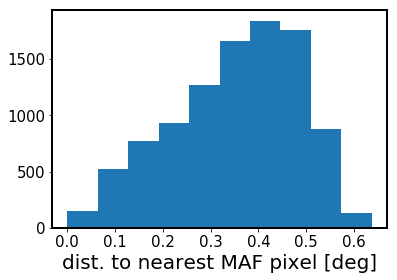

In [16]:
# So all nearest-match MAF pixels are within 
# the half-diagonal of the DECam image mosaic..
plt.hist(decaps_maf['d2d_deg'])
plt.xlabel('dist. to nearest MAF pixel [deg]')

In [18]:
# Save the imdb - MAF table ... 
decaps_maf.write('decapsIMDB_MAF_table', format='ascii')

(-70, -20)

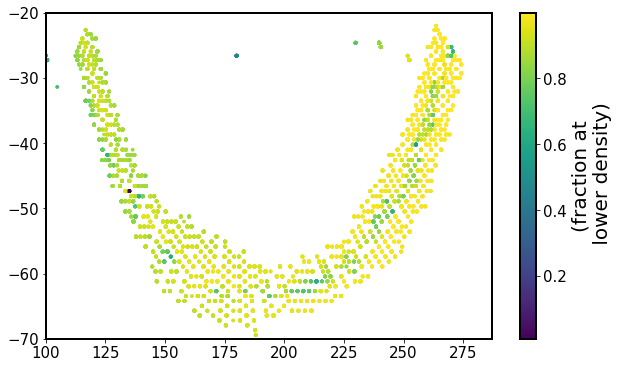

In [116]:
# Plot the DECAPS fields colored by MAF densities 
fig,ax = plt.subplots(1,1,figsize=(10,6))
imge = ax.scatter(np.degrees(decaps_maf['ra_rad']), np.degrees(decaps_maf['dec_rad']),
            c = 1-decaps_maf['frac_greater'],
                  s=8)
plt.colorbar(imge, label='(fraction at\n lower density)')
ax.set_xlim(100,)
ax.set_ylim(-70,-20)

(array([  1.99200000e+03,   1.29600000e+03,   1.19600000e+03,
          8.54000000e+02,   9.85000000e+02,   7.85000000e+02,
          5.83000000e+02,   4.18000000e+02,   4.28000000e+02,
          4.34000000e+02,   1.34000000e+02,   8.00000000e+01,
          9.60000000e+01,   9.20000000e+01,   7.70000000e+01,
          8.20000000e+01,   4.70000000e+01,   1.40000000e+01,
          0.00000000e+00,   2.10000000e+01,   3.80000000e+01,
          1.55000000e+02,   2.30000000e+01,   0.00000000e+00,
          1.00000000e+00,   2.80000000e+01,   1.50000000e+01,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]),
 array([ 0.        ,  0.01666667,  0.03333333,  0.05      ,  0.06666667,
         0.08333333,  0.1       ,  0.11666667,  0.13333333,  0.15      ,
         0.16666667,  0.18333333,  0.2       ,  0.21666667,  0.23333333,
         0.25      ,  0.26666667,  0.28333333,  0.3       ,  0.31666667,
         0.33333333,  0.35      ,  0.36666667,  0.38333333,  0.4       ,
         0.41

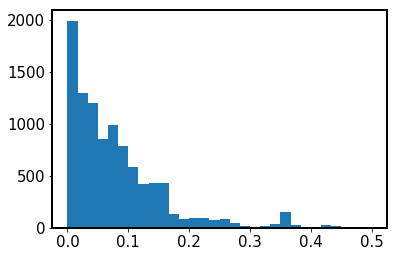

In [117]:
plt.hist(decaps_maf['frac_greater'], range=(0,0.5), bins=30)

Now we make cuts to make the filter and exptime similar to LSST single-visit depth :

In [118]:
np.unique(decaps_maf['filterid'])

Y.0000
g.0000
i.0000
r.0000
z.0000


In [120]:
decaps_maf

visit,prodtype,exptime,mjd_obs,filterid,ra,dec,sb_name,magzero,catfname,dtnsanam,source_density,ra_rad,dec_rad,N_px_greater,frac_greater,d2d_deg
str6,str5,float64,float64,str6,float64,float64,str31,float64,str35,str26,float64,float64,float64,float64,float64,float64
525807,image,5.0,57460.9927059,r.0000,96.1841,-28.77976,c4d_160313_235023_ooi_r_v1.fits,26.832,c4d_160313_235023_ooi_r_v1.cat.fits,c4d_160313_235023_ori.fits,22248.0,1.68124294352,-0.499705040759,16103.0,0.415196988449,0.195167667822
525808,image,96.0,57460.9969294,g.0000,100.0008,-26.92384,c4d_160313_235804_ooi_g_v1.fits,29.646,c4d_160313_235804_ooi_g_v1.cat.fits,c4d_160313_235804_ori.fits,29196.0,1.74260217504,-0.464433821075,13913.0,0.35873040429,0.343651151172
525809,image,96.0,57460.998373,g.0000,99.83377,-27.073,c4d_160314_000006_ooi_g_v1.fits,29.623,c4d_160314_000006_ooi_g_v1.cat.fits,c4d_160314_000006_ori.fits,29196.0,1.74260217504,-0.464433821075,13913.0,0.35873040429,0.46298782973
525810,image,96.0,57460.9998095,g.0000,100.1685,-27.07277,c4d_160314_000215_ooi_g_v1.fits,29.629,c4d_160314_000215_ooi_g_v1.cat.fits,c4d_160314_000215_ori.fits,29232.0,1.75487402134,-0.476119060912,13907.0,0.35857570132,0.395077683453
525811,image,30.0,57461.001244,r.0000,100.0015,-26.9232,c4d_160314_000308_ooi_r_v1.fits,28.844,c4d_160314_000308_ooi_r_v1.cat.fits,c4d_160314_000308_ori.fits,29196.0,1.74260217504,-0.464433821075,13913.0,0.35873040429,0.343323039878
525812,image,30.0,57461.0019313,r.0000,99.83334,-27.07106,c4d_160314_000408_ooi_r_v1.fits,28.832,c4d_160314_000408_ooi_r_v1.cat.fits,c4d_160314_000408_ori.fits,29196.0,1.74260217504,-0.464433821075,13913.0,0.35873040429,0.461055761477
525813,image,30.0,57461.002617,r.0000,100.1688,-27.07151,c4d_160314_000514_ooi_r_v1.fits,28.887,c4d_160314_000514_ooi_r_v1.cat.fits,c4d_160314_000514_ori.fits,29232.0,1.75487402134,-0.476119060912,13907.0,0.35857570132,0.39551344629
525814,image,96.0,57461.0044199,g.0000,126.4261,-43.06979,c4d_160314_000848_ooi_g_v1.fits,29.4545,c4d_160314_000848_ooi_g_v1.cat.fits,c4d_160314_000848_ori.fits,76572.0,2.20659484002,-0.743681425399,7944.0,0.204826732673,0.459986592029
525815,image,30.0,57461.0058628,r.0000,126.426,-43.07055,c4d_160314_000944_ooi_r_v1.fits,28.8275,c4d_160314_000944_ooi_r_v1.cat.fits,c4d_160314_000944_ori.fits,76572.0,2.20659484002,-0.743681425399,7944.0,0.204826732673,0.460746880324


In [121]:
# choose   90 sec < exposure < 125 sec 
# dec < 0  
# filter is  u, g, r,  or VR 
# although it seems that DECAPS has only 
# g,r,i,z,Y ... 

mask_filter = (decaps_maf['filterid'] == 'r.0000') | (decaps_maf['filterid'] == 'g.0000')
print(np.sum(mask_filter))

mask_exp  = (decaps_maf['exptime'].data > 90 ) * (decaps_maf['exptime'] < 125)
print(np.sum(mask_exp))

print(np.sum(mask_exp * mask_filter))

# see what fractions are available...
mask = mask_exp * mask_filter
#np.unique(decaps_maf[mask]['frac_greater'])

4139
2043
2043


In [131]:
selected = decaps_maf[mask]
len(selected)

2043

In [134]:
densities = [5,10,15,20,25]
selected['density'] = 1
for density in densities : 
    perc = 100*selected['frac_greater'] 
    mask_density = ((density-1) < perc) * (perc < (density+1))
    print(density, np.sum(mask_density))
    selected['density'][mask_density] = density 

5 267
10 193
15 78
20 22
25 23


In [146]:
densities[1:]

[10, 15, 20, 25]

In [150]:
from astropy.table import vstack

# print only 5% regions 
selected_visits = selected[selected['density'] == 5][:2]

for density in densities[1:]:
    add = selected[selected['density'] == density][:2]
    selected_visits = vstack([selected_visits, add])
    

In [176]:
#In this way I selected 10 visits : two at each density level : 
selected_visits[['density','sb_name','ra','dec', 'exptime', 'visit', 'source_density']]

density,sb_name,ra,dec,exptime,visit,source_density
int64,str31,float64,float64,float64,str6,float64
5,c4d_160314_023031_ooi_g_v1.fits,140.5531,-51.24729,96.0,525904,594324.0
5,c4d_160314_025458_ooi_g_v1.fits,143.2337,-51.44724,96.0,525920,588096.0
10,c4d_160314_005746_ooi_g_v1.fits,133.5462,-44.27313,96.0,525846,203040.0
10,c4d_160314_015142_ooi_g_v1.fits,137.6415,-54.08343,96.0,525879,198432.0
15,c4d_160314_004325_ooi_g_v1.fits,131.5622,-48.59523,96.0,525837,114588.0
15,c4d_160314_004531_ooi_g_v1.fits,132.5935,-50.30486,96.0,525838,116676.0
20,c4d_160314_000848_ooi_g_v1.fits,126.4261,-43.06979,96.0,525814,76572.0
20,c4d_160314_022428_ooi_g_v1.fits,140.6165,-48.15003,96.0,525900,79632.0
25,c4d_160314_034142_ooi_g_v1.fits,149.739,-57.89337,96.0,525951,52920.0


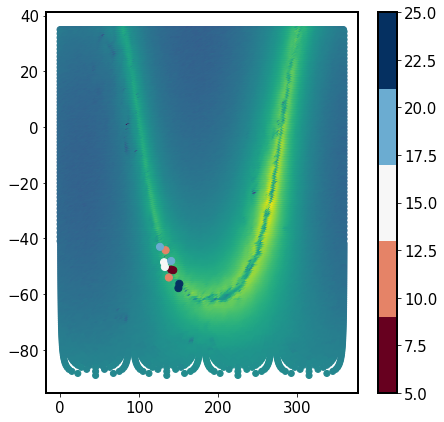

In [218]:

fig,ax = plt.subplots(1,1,figsize=(7,7))
ax.scatter(healpix_coords.ra.deg, healpix_coords.dec.deg,c=z)
d = len(np.unique(selected_visits['density']))
cmap = plt.get_cmap('RdBu', d) 
image = ax.scatter(selected_visits['ra'], selected_visits['dec'], s=50,
           c=selected_visits['density'],
           cmap=cmap)
plt.colorbar(image)

Now I need to obtain the dqmask, wtmap, instcal for these visits to do the LSST processing... I can do that by making an SQL query against the NOAO Public Archive using the fact that the proposal id is characteristic of images obtained ... 

In [124]:
# The propid for the DECAPS is '2016A-0327' and '2016B-0279' : 
np.unique(imdb['propid'])

2016A-0327
2016B-0279


Thus, I would execute a query : 

    SELECT *  FROM voi.siap WHERE ((dtpropid ILIKE '%2016A-0327%') OR (dtpropid ILIKE '%2016B-0279%')) AND (proctype = 'InstCal')) LIMIT 50000

It results in 46890 rows, and I can use these to extract the names of dqmask, wtmap corresponding to my chosen visits. 

I'm having trouble reading the results of this query, so I split it into  two queries : 


    SELECT *  FROM voi.siap WHERE dtpropid ILIKE '%2016A-0327%' AND proctype = 'InstCal' LIMIT 50000

yields 11538 rows 

    SELECT *  FROM voi.siap WHERE dtpropid ILIKE '%2016B-0279%' AND proctype = 'InstCal' LIMIT 50000


In [125]:
# from a file that has imaging, wtmap,  dqmask, select only desired rows ...
fname = 'rows_as_votable_1516932989_6863.vot.xml'  # imaging, dqmask ,wtmap 
import astropy.io.votable as vo

#table = parse_single_table(fname)
#decaps_all = table.to_table()
vo.is_votable(fname)
#fname = 'rows_as_votable_1516932680_713.vot.xml'
table = vo.parse_single_table(fname, invalid='mask')
decaps_rows = table.to_table()

In [173]:
# Test on one object in 5% region : 
# what are the dqmask, instcal, wtmap ? 
mask_rows = np.in1d(decaps_rows['dtnsanam'].data.data.astype(str), 
                    'c4d_160314_023031_ori.fits')
decaps_rows[mask_rows]['dtacqnam','prodtype', 'exposure', 'dtnsanam', 'filter']

dtacqnam,prodtype,exposure,dtnsanam,filter
object,object,float64,object,object
/data_local/images/DTS/2016A-0327/DECam_00525904.fits.fz,wtmap,96.0,c4d_160314_023031_ori.fits,g DECam SDSS c0001 4720.0 1520.0
/data_local/images/DTS/2016A-0327/DECam_00525904.fits.fz,image,96.0,c4d_160314_023031_ori.fits,g DECam SDSS c0001 4720.0 1520.0
/data_local/images/DTS/2016A-0327/DECam_00525904.fits.fz,dqmask,96.0,c4d_160314_023031_ori.fits,g DECam SDSS c0001 4720.0 1520.0


All we need to do now is to select few visits in each density,  and grab these rows from the votable, and save as votable 

In [156]:
selected_visits['dtnsanam'].data.astype(str)

array(['c4d_160314_023031_ori.fits', 'c4d_160314_025458_ori.fits',
       'c4d_160314_005746_ori.fits', 'c4d_160314_015142_ori.fits',
       'c4d_160314_004325_ori.fits', 'c4d_160314_004531_ori.fits',
       'c4d_160314_000848_ori.fits', 'c4d_160314_022428_ori.fits',
       'c4d_160314_034142_ori.fits', 'c4d_160314_034340_ori.fits'],
      dtype='<U26')

In [157]:
decaps_rows['dtnsanam'].data.data.astype(str)

array(['c4d_160313_235023_ori.fits', 'c4d_160313_235023_ori.fits',
       'c4d_160313_235023_ori.fits', ..., 'c4d_160327_100604_ori.fits',
       'c4d_160327_100604_ori.fits', 'c4d_160327_100604_ori.fits'],
      dtype='<U26')

In [158]:
select = np.in1d(decaps_rows['dtnsanam'].data.data.astype(str), 
                 selected_visits['dtnsanam'].data.astype(str))

# thus there should be 3*10( dqmask+wtmap+instcal) 
assert np.sum(select) == 3*10

In [169]:
# Display what we have found ... 
decaps_rows[select]['dtnsanam', 'prodtype', '']

ValueError: Slice name(s) mjdobs not valid column name(s)

In [174]:
# save that list of archive filenames 
# as a VOTable to download 
# with secure get 
N = np.sum(select)
fname = 'decaps_NOAO_download_votable_'+str(N)+'.vot.xml'
decaps_rows[select].write(fname,format='votable',
                          overwrite=True)
print('We saved %d names to download as %s'%(N,fname))

We saved 30 names to download as decaps_NOAO_download_votable_30.vot.xml


Now first we need to scp the NCSA the `secure_get.sh`  script:
    
    scp secure_get.sh scichris@lsst-dev.ncsa.illinois.edu:/home/scichris/ 

Now scp to NCSA the VO Table with files to download : 
 
    scp decaps_NOAO_download_votable_30.vot.xml scichris@lsst-dev.ncsa.illinois.edu:/home/scichris/ 

Now ssh to NCSA to download the data from NOAO:
    
    ssh scichris@lsst-dev01.ncsa.illinois.edu
    ./secure_get.sh decaps_NOAO_download_votable_30.vot.xml        
        
Then move the files to correct directories: 
    
    mv c4d*ood*   noao_files/dqmask/
    mv c4d*ooi*   noao_files/instcal/
    mv c4d*oow*   noao_files/wtmap/
    
Then load the LSST Stack tools, and ingest the images to repo : 

    source /ssd/lsstsw/stack/loadLSST.bash
    setup obs_decam
    ingestImagesDecam.py repo/ noao_files/instcal/c4d_160314*.fits.fz
    
Now, ready for processing,  open the detached tmux session and run the processCcd on 5% : 

    tmux 
    processCcd.py repo --rerun proc5perc  --id visit=525904^525920  -C config_processccd.py --clobber-config --clobber-versions  > procmore05.log
    
Detach from tmux session by 

    ctrl+b followed by d 
    
We can check the progress of the processing by either displaying few last lines of the log file, or checking the length of the log file : 

    tail procmore05.log 
    wc -l procmore05.log 
    
Then I run the next density level : 10% : 
    
    tmux 
    processCcd.py repo --rerun proc10perc  --id visit=525846^525879    -C config_processccd.py --clobber-config --clobber-versions  > procmore10.log
    
Thanks to a command that checks which processes are running, I find that the 10% process is no longer running, so I run it again  :procmore10_2.log 

    ps aux | grep scichris
    
Then I run 15% : 

    tmux 
    processCcd.py repo --rerun proc15perc  --id visit=525837^525838    -C config_processccd.py --clobber-config --clobber-versions  > procmore15.log
   
And 20% : 

    tmux 
    processCcd.py repo --rerun proc20perc  --id visit=525814^525900    -C config_processccd.py --clobber-config --clobber-versions  > procmore20.log
    
And 25% : 

    tmux 
    processCcd.py repo --rerun proc25perc  --id visit=525951^525952    -C config_processccd.py --clobber-config --clobber-versions  > procmore25.log